# Differential Privacy (DP)

- Used to answer (numeric) queries.
- Analyst can't decide if an individual's data was used or not to answer the query.
- Laplace mechanism (adding Laplacian noise) satisfies DP.
- More privacy = Smaller $\varepsilon$ = More noise = Less accuracy
- More accuracy = less noise = larger $\varepsilon$ = less privacy
- Sequential composition: It is safe to answer multiple queries about the same dataset. The privacy cost is adding up.

## Parallel Composition

 - Splitting the dataset into disjoint chunks
 - Running a differentially private mechanism on each chunk separately.

 - The chunks are disjoint, so each individual's data appears in exactly one chunk.
 - The mechanism runs exactly once on the data of each individual.
  
> ### Theorem (Parallel Composition) 
> Suppose that $M$ satisfies $\varepsilon$-differential privacy. Split datast $D$ into disjoint chunks, such that $D =D_1 \cup \dots D_k$. Then the mechanism which releases $M(D_1),\dots,M(D_k)$ satisfies $\varepsilon$-differential privacy.
 
  - The budget of running $k$ $\varepsilon$-DP algortihm on disjoint chunks of dataset gives a privacy budget $\varepsilon$ instead of $k\varepsilon$.

### Histograms

Anaysis of a dataset which splits the dataset into "bins" based on value of one of the data attributes, and counts the number of rows in each bin.

Example: Count the number of people in the dataset who achieved a particular educational level.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
adult = pd.read_csv("adult_with_pii.csv")
adult['Education'].value_counts().to_frame().head(5)

,Education
HS-grad,10501
Some-college,7291
Bachelors,5355
Masters,1723
Assoc-voc,1382


 - Histograms automatically satisfy parallel composition.
 - Each "bin" in a histogram is defined by a possible value for a data attribute (e.g., 'Education' = 'Bachelor's degree')

In [4]:
epsilon = 1

# This analysis has a total privacy cost of epsilon = 1, even though we release many results!
f = lambda x: x + np.random.laplace(loc=0, scale=1/epsilon)
s = adult['Education'].value_counts().apply(f)
s.to_frame().head(5)

,Education
HS-grad,10500.253580
Some-college,7289.475379
Bachelors,5355.529765
Masters,1723.073338
Assoc-voc,1385.325493


### Contingency Tables (Cross tabulation)

 - Like a multi-dimensional histogram.
 - It counts the frequency of rows in the dataset with particular values for more than one attribute at a time.
 - Contingency tables are frequently used to show the relationship between two variables when analyzing data.
 - E.g., we might want to see counts based on both education level and gender

In [5]:
pd.crosstab(adult['Education'], adult['Sex']).head(5)

Sex,Female,Male
Education,,
10th,295,638
11th,432,743
12th,144,289
1st-4th,46,122
5th-6th,84,249


 - Each individual participates in eaxctly one count.
 - It is safe to use parallel composition.

In [6]:
ct = pd.crosstab(adult['Education'], adult['Sex'])
f = lambda x: x + np.random.laplace(loc=0, scale=1/epsilon)
ct.applymap(f).head(5)

Sex,Female,Male
Education,,
10th,292.319766,637.894232
11th,432.874968,742.203356
12th,143.712783,290.310824
1st-4th,46.299542,123.464276
5th-6th,84.791060,248.893246


## Post-processing

 - Informally: It is impossible to reverse the privacy protection provided by DP by post-processing the data in some way.
 
 > ### Post processing
 > If $M$ satisfies DP, then for any function $g$, $g(M)$ satisfies $\varepsilon$-DP.

 - It is safe to perform post-processing that might reduce the noise or improve the signal in the mechanism's output.
  - Once we put DP on a data, it always remains on it.

 - DP provide resistance against privacy attacks based on auxiliary information.
  - E.g., function $g$ might contain auxiliary inforamtion.
  - Linkage attacks based on this information are limited in its effectivenss by the parameter $\varepsilon$.

### Summary

 - Sequential composition bounds the total privacy cost of multiple release of the data when apply DP
 - Parallel composition is based on splitting the dataset into disjoint chunks and run the DP mechanism separately. The privacy cost is only the cost of one DP mechanism.
 - Post-processing property means that it is safe to perform arbitrary computations on the output of DP, in particular it is protect against attacks based on auxiliary inforamtion.

## Sensitivity

 - The amount of the function's output can change if the input changes.
 - Let $f: \mathcal{D} \rightarrow \mathbb{R}$ be a function. Then $$S(f) = \max_{x,x':d(x,x')\le 1} |f(x) - f(x')|$$
 - If $f$ is a count query, then $S(f) = 1$.
 - If $f$ is the age sum query, then $S(f)$ is the maximal possible age of an individual.
 - It is often challenging to compute the sensitivity. We will discuss this later.

### How to Calculate Sensitivity

What is the sensitivity of the following functions?
 1. $f(D):$ number of individuals in the dataset? 
 2. $f(D):$ number of individuals with salary '100k to 200k'?
 3. $f(D):$ sum of Zip codes, age, income?
 4. $f(D):$ mean of the age (outcome) of individuals?

 1. Count query: 1
 2. Count query: 1
 3. Difference between the min and max value:
     - Zip code: 0 and 99999.
     - Age: 0 and 125? In our dataset: 18 and 65.
     - Income: ? and ? 
 4. Problem: The size of the dataset might be sensitive .
     - Compute a sum and a count query and output the quotient.

What is the average age of people with educational grade 'Masters' degree?

In [7]:
adult[adult['Education'] == 'Masters']['Age'].mean()

44.04991294254208

In [8]:
adult[adult['Education'] == 'Masters']['Age'].sum() / adult[adult['Education'] == 'Masters']['Age'].shape[0]

44.04991294254208

In [9]:
epsilon = 0.5
age_min, age_max = 18, 65
sensitivity = age_max - age_min
num = adult[adult['Education'] == 'Masters']['Age'].sum() + np.random.laplace(loc=0, scale=sensitivity/epsilon)
denom = adult[adult['Education'] == 'Masters']['Age'].shape[0] + np.random.laplace(loc=0, scale=1/epsilon)
num / denom

43.89913531155309

 - Queries with unbounded sensitivity cannot be directly answered with DP using Laplace mechanism.
 - Idea: Transform the queries into equivalent queries with bounded sensitivity. 
 - But how?

### Clipping
 - Enforce upper and lower bounds on attribute values.
 - Clip values that are above or below some given value.
 - For example, age can be clipped to 125 (or 100).

In [10]:
adult['Age'].clip(lower=0, upper=125).sum()

1256257

**Problem:** How to determine the upper and lower bounds?  

There is a trade-of between information lost in clipping and the noise needed to ensure DP. 
 - If upper and lower bounds are closer, then the sensitivity is lower, so less noise is needed.
 - Aggressive clipping often removes a lot of informationfrom the data. 

*Rule of thumb:* try to set the clipping bounds to include 100% of the dataset, or get as close as possible.

How to determine the upper and lower bounds?  
 - Why don't we look at the data? For example, we can look at the histogram of ages in our dataset to determine an appropriate upper bound. 

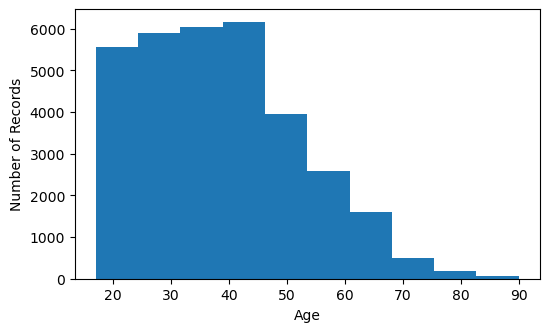

In [11]:
plt.figure(figsize=(6,3.5))
plt.hist(adult['Age'])
plt.xlabel('Age')
plt.ylabel('Number of Records');

*Problem:* **This approach does not satisfy differential privacy**. If we pick our bound by looking at the data, then the bound themselves might receal something about the data.

Typically clipping bounds are decided by:
 - Using the property of the dataset that can be known without looking at the data (e.g., ages are between 0 and 125).
 - Perform differentially private queries to evaluate the different choices for clipping bounds.

Set the lower bound and slowly inrease the upper bound until the query's output stops changing.  

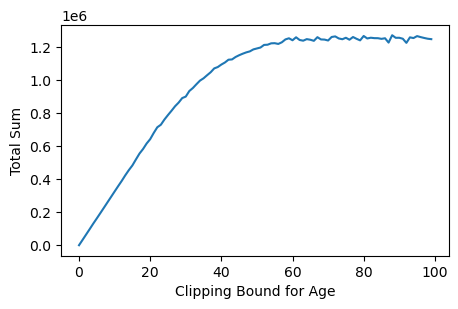

In [12]:
def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity/epsilon)

epsilon_i = .01
plt.figure(figsize = (5, 3))
plt.plot([laplace_mech(adult['Age'].clip(lower=0, upper=i).sum(), i, epsilon_i) for i in range(100)])
plt.xlabel('Clipping Bound for Age')
plt.ylabel('Total Sum');

 - The total privacy cost is $\varepsilon = 100$, because we do 100 queries.
 - The results stopped increasing around 70, so this is a good choice for upper clipping bound-

# Approximate Differential Privacy

> Algorithm $M$ is $(\varepsilon,\delta)$-differentially private if the following holds: $$\Pr[M(D) = S] \le e^\varepsilon \Pr[M(D') = S] + \delta$$

The difference between $\epsilon$-DP is the term $\delta$. What is the meaning of $\delta$? 

Informally it guarantee $\varepsilon$-DP with probability $1 -\delta$ and with $\delta$ probability there is no quarantee on privacy.

 - With probability $1 - \delta$, $\frac{\Pr[M(D)=S]}{\Pr[M(D')=S]} \le e^\varepsilon$
 - With probability $\delta$, there is no quarantee at all.

No guarantee? What could happen?

 - With $\delta$ probability, the algorithm can release the entire dataset with all the sensitive information. Therefore $\delta$ should be small, e.g., $\frac{1}{n^2}$, where $n$ is the size of the dataset.
 - In practice, however, it doesn't seems to release a lot of sensitive information.

### Sequential Composition

>If $M_1,M_2$ satisfies $(\varepsilon_1,\delta_1)$-, and $(\varepsilon_2,\delta_2)$-DP, then the mechanism $M = (M_1,M_2)$, which release both results satisfies $(\varepsilon_1 + \varepsilon_2,\delta_1 + \delta_2)$-DP.

Approximate DP also satisfies post-processing and parallel composition.

## Gaussian Mechanism

 - The Gaussian mechanism is an alternative to the Laplave mechanism.
 - Adds Gaussian noise instead of Laplacian noise.
 - It does not satisfy $\varepsilon$-DP (pure DP).
 - It satisfies $(\varepsilon,\delta)$-DP.

 > Let $f$ be a function which returns a number. Mechanism $M$ satisfies $(\varepsilon,\delta)$-DP, if $$M(D) = f(D) + \mathcal{N}(\sigma^2)$$ 
 > where $\sigma^2 = \frac{2s^2\log(1.25/\delta)}{\varepsilon^2}$, $s$ is the sensitivity of $f$ and $\mathcal{N}$ denotes sampling from Gaussian (normal) distribution with center 0 and variance $\sigma^2$. 

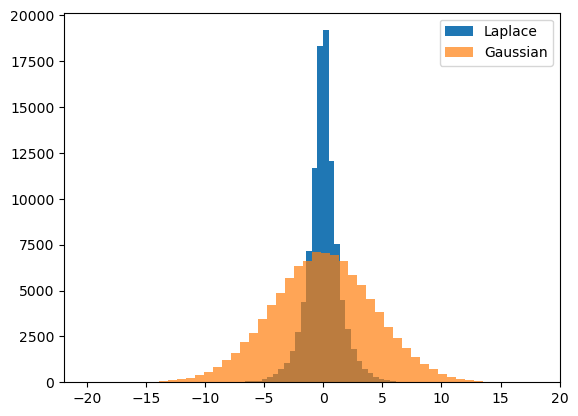

In [13]:
epsilon = 1
vals_laplace = [np.random.laplace(loc=0, scale=1/epsilon) for x in range(100000)]

delta = 10e-5
sigma = np.sqrt(2 * np.log(1.25 / delta)) * 1 / epsilon
vals_gauss = [np.random.normal(loc=0, scale=sigma) for x in range(100000)]
 
plt.hist(vals_laplace, bins=50, label='Laplace')
plt.hist(vals_gauss, bins=50, alpha=.7, label='Gaussian');
plt.legend();

### Comparison of precision

 - Laplace mechanism looks much more pointy, while Gaussian mechanism looks "squished". 
 - This results in a smaller amount of noise in Laplace mechanism. 
 - Laplace mechanism is more accurate.

|-               | Laplace mechanism | Gaussian mechanism |
|----------------|-------------------|--------------------|
|Fail            | No fail           | Fail with $\delta$ prob.|
|Accuracy        | More accurate     | Less accurate      |

## Vector-Valued Function and Their Sensitivities

### Sensitivity in 1-dimension

$$S(f) = \max_{x,x':d(x,x')\le 1} |f(x) - f(x')|$$

How to compute sensitivity of vector valued functions?

### L1 norm

> The $L1$ norm of a vector $v$ of length $k$ is defined as $\|V\|_1 = \sum_{i=1}^k |V_i|$ (i.e., the sum of the vector's elements). 

The $L1$ norm of the difference between two vectors yields the "manhattan distance" between them.

- $\|(3)\|_1 = 3$
- $\|(3, 2, -4)\|_1 = 3 + 2 + 4 = 9$
- $\|(-2, 0, -1.4, 6.25)\|_1 = 2 + 0 + 1.4 + 6.25 = 9.65$

### L2 norm 

> The $L2$ norm of a vector $v$ of length $k$ is defined as $\|V\|_2 = \sqrt{\sum_{i=1}^k V_i^2}$ (i.e., the square root of the sum of the squares)

The $L2$ norm of the difference between two vectors yields the "Euclidean distance" between them.

 - $\|(3)\|_2 = 3$
 - $\|(3, -4)\|_2 = \sqrt{3^2 + (-4)^2} = \sqrt{25} = 5$
 - $\|(2, -1.5, \sqrt{3})\|_2 = \sqrt{4 + 2.25 + 3} =\sqrt{9.25} = 3.04$. 

### L1 sensitivity

 > $$S(f) = \max_{x,x':d(x,x')\le 1} \|f(x) - f(x')\|_1$$
 
 This is equal to the sum of the elementwise sensitivities. If $f$ returns a vector of length $k$ of 1-sensitive results, then the $L1$ sensitivity is $k$.

 ### L2 sensitivity
 
 > $$S(f) = \max_{x,x':d(x,x')\le 1} \|f(x) - f(x')\|_2$$
 
 For the same examples as above, the $L2$ sensitivity is $\sqrt{k}$.

### DP for Vector Valued Mechanisms

Both Lapalce and Gaussian mechanism can be extended to vector-valued function.

 - Laplace mechanism require $L1$ senitivity.
 - Gaussian mechanism allows either $L1$ or $L2$ sensitivity.

 - The vector-valued Laplace mechanism releases $f(x) + (Y_1,\dots,Y_k)$, where $Y_i$ are drawn i.i.d. from the Laplace distribution with scale $\frac{s}{\varepsilon}$ and $s$ is the $L1$ sensitivity of $f$.
 - The vector-valued Gaussian mechanism releases $f(x) + (Y_1,\dots,Y_k)$, where $Y_i$ are drawn i.i.d. from the Gaussian distribution with $\sigma^2 = \frac{2s^2\log(1.25/\delta)}{\varepsilon^2}$ and $s$ is the $L2$ sensitivity of $f$.

## The Catastrophe Mechanism

 - The definition of $(\varepsilon,\delta)$-DP says that the mechanism must "behave well" with probability $1-\delta$. 
 - With probability $\delta$, the mechanism fails, anything can happen, there is no privacy quarantee.

 > ### Catastrophe Mechanism
 > M(q,x) = Sample a number $r$ from the uniform distribution between 0 and 1.
 >  - If $r < \delta$, return $x$.
 >  - Otherwise, return $q(x) + Lap(s/\varepsilon)$, where $s$ is the sensitivity of $q$.

 - With probability $1-\delta$, the mechanism satisfies $\varepsilon$-DP.
 - With probability $\delta$, it releases the whole dataset with no noise.
 
 The mechansim satisfies $(\varepsilon,\delta)$-DP, but shouldn't be used in practice. How much information Gaussian mechanism might release?

 How much information Gaussian mechanism releases when fails? 
  
  - With the $\delta$ prob., Gaussian mechanism satisfies $c\varepsilon$-DP for some value $c$.
  - Gaussian mechanism fails gracefully (rather than catastrophically). 

## Advanced Composition

We can combine DP mechanism with sequential composition and parallel composition.
 - Sequential composition: If we ask multiple queries of the same dataset, then the privacy cost is adding up.

 > ### Adaptive Composition
 > A$k$-fold adaptive compositiob is a sequence of mechanisms $m_1,\dots,m_k$ suh that:
 > - Each mechanism $m_i$ may be chosen based on the outputs of all previous mechanisms $m_1,\dots,m_{i-1}$ (hence adaptive)
 > - The input to each mechanism $m_i$ is both the private dataset and all of the outputs of previous mechanisms (hence composition)

In [14]:
# works for sensitivity-1 queries
def avg_attack(query, epsilon, k):
    results = [query + np.random.laplace(loc=0, scale=1/epsilon) for i in range(k)]
    return np.mean(results)

avg_attack(10, 1, 500)

9.930081828336505

 - The sequence of mechanism is fixed ahead of time
 - $k = 500$.
 - Privacy cost from standard sequential composition is $500\varepsilon$ ($k\varepsilon$).
 - Is this tight?    

 > ### Theorem (Advanced Compostion)
 > - If each mechanism $M_i$ in a $k$-fold adaptive composition $M_1,\dots,M_k$ satisfies $\varepsilon$-DP, then for any $\delta' \ge 0$, the entire $k$-fold adaptive composition satisfies $(\varepsilon',\delta')$-DP, where $$\varepsilon' = 2\varepsilon\sqrt{2k\log(1/\delta')}$$

### Comparision

 - With $\varepsilon = 1$, $\delta' = 10^{-5}$, we get $$\varepsilon' = 2\sqrt{1000 \log(10^5)} \approx 214.59.$$
 - So advanced composition derives a much lower bound on $\varepsilon'$.
 - They are still not tight, just slightly less losse than the ones given by sequential composition.

 - The bounds are technically incomperables, since advanced composition introduce a $\delta$.
 - Sequential composition can still give lower privacy cost based on the numver of queries.

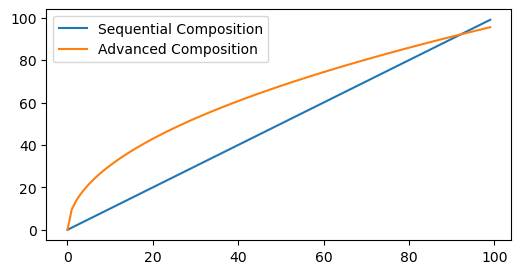

In [18]:
epsilon = 1
delta = 1e-5

def adv_comp(k):
    return 2*epsilon*np.sqrt(2*k*np.log(1/delta))

def seq_comp(k):
    return k*epsilon

plt.figure(figsize=(6,3))
plt.plot([seq_comp(k) for k in range(100)], label='Sequential Composition')
plt.plot([adv_comp(k) for k in range(100)], label='Advanced Composition')
plt.legend();

 - Standard sequential composition beats advanced composition, if $2\sqrt{2k \log (1/\delta')} > k$.
 - If $\delta' = 1/10^5$, then $k > 92$. 

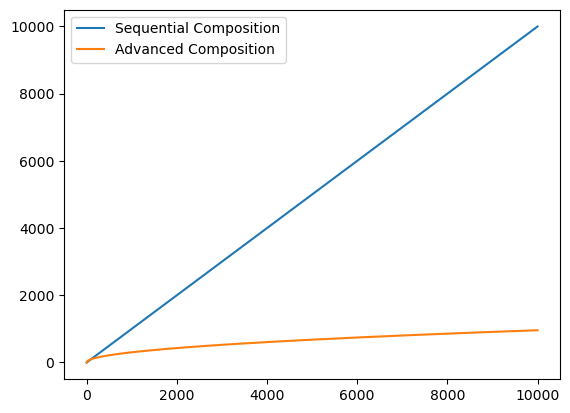

In [16]:
plt.plot([seq_comp(k) for k in range(10000)], label='Sequential Composition')
plt.plot([adv_comp(k) for k in range(10000)], label='Advanced Composition')
plt.legend();

### Advanced Composition for Approximate DP

 - The previous theorem for advanced composition works only for pure DP.
 - Thre is more general version for approximate DP.
 
 > ### Theorem (Approximate Advanced Composition)
 > If each mechanism $M_i$ in a $k$-fold adaptive composition $M_1,\dots,M_k$ satisfies $(\varepsilon,\delta)$-DP, then for any $\delta' \ge 0$, the entire $k$-fold adaptive composition satisfies $(\varepsilon',k\delta + \delta')$-DP, where $$\varepsilon' = 2\varepsilon\sqrt{2k\log(1/\delta')}$$
 
 - The only difference is the additional $k\delta$ term. If $\delta = 0$, then the statement simplifies for the preious one.